# Train Bandits with per-arm features

**Exploring linear and nonlinear** (e.g., those with neural network-based value functions) bandit methods for recommendations using TF-Agents

> Neural linear bandits provide a nice way to leverage the representation power of deep learning and the bandit approach for uncertainty measure and efficient exploration

### Objectives

In this notebook, we explore the following topics for training contextual bandits with per-arm features:

1. Data preperation
2. Sampling functions
3. TensorSpecs
4. Agent, Network, training policy
5. Reward function
6. Trajectory function
7. Train & Eval loops
8. Getting predictions -
9. Preparing the training application - abstracting all steps above to be used in subsequent notebooks

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
# pip install tensorflow-probability==0.23.0 --force-reinstall

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import time
import functools
import collections
import pickle as pkl
from pprint import pprint
from collections import defaultdict
from datetime import datetime
from typing import Callable, Dict, List, Optional, TypeVar

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf

# tf-agents
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import export_utils
from tf_agents.policies import policy_saver
from tf_agents.trajectories import trajectory
from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.utils import train_utils, reward_factory
from src.data import data_utils, data_config
from src.trainer import eval_perarm as eval_perarm, train_perarm
from src.agents import agent_factory as agent_factory
from src.networks import encoding_network as emb_features

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-07-01 19:29:37.766620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
device = cuda.get_current_device()
device.reset()
gc.collect()

31

In [7]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# [1] Data prep

**Overview**
* Load train and eval datasets from TFRecords created in the `01-movielens-data-prep.ipynb` notebook
* training examples represent historical (previously collected) interaction data 

In [8]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

!gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v4/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v5/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/


### Read TF Records

In [9]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

**Train data**

In [10]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files[:3]
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-001-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-002-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-003-of-008.tfrecord']

In [11]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'prog

**Val data**

In [12]:
SPLIT = "val"

val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(data_utils._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

### get vocab

**TODO:** 
* streamline vocab calls

In [13]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



In [14]:
# vocab_dict['user_occupation_text']

# [2] Preprocessing layers for global and arm features

The preproccesing layers will ultimately feed the two sampling functions described below. These sampling functions will be used to create [trajectories](https://github.com/tensorflow/agents/blob/master/tf_agents/trajectories/trajectory.py#L36) (i.e., the training examples for our model)

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). * This output is the per-arm context. Its shape must be consistent across calls.

See `debug-and-learn-emb-models.ipynb` for more details and debugging

## Global & Per-Arm feature embedding models 

**get expected dimensions**

**common layers**
* layer sizes for the final tower
* The network that takes as input the concatenation of 
  the outputs of the global and the arm networks
*  hidden layers ideally divisible by 8, e.g., [16, 32, 64, 128, 256, 512]

In [15]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 12
MV_EMBEDDING_SIZE      = 16

NUM_GLOBAL_FEATURES = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES    = len(data_utils.MOVIE_FEATURE_NAMES)    # 5
EXPECTED_GLOBAL_DIM  = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
EXPECTED_PER_ARM_DIM = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES
print(f"EXPECTED_GLOBAL_DIM: {EXPECTED_GLOBAL_DIM}")
print(f"EXPECTED_PER_ARM_DIM: {EXPECTED_PER_ARM_DIM}")

EXPECTED_GLOBAL_LAYERS   = [
    EXPECTED_GLOBAL_DIM, 
    int(EXPECTED_GLOBAL_DIM/2), 
    int(EXPECTED_GLOBAL_DIM/4)
]
EXPECTED_ARM_LAYERS      = [
    EXPECTED_PER_ARM_DIM, 
    int(EXPECTED_PER_ARM_DIM/2), 
    int(EXPECTED_PER_ARM_DIM/4)
]
EXPECTED_FIRST_COMMON_LAYER = EXPECTED_GLOBAL_LAYERS[-1] + EXPECTED_ARM_LAYERS[-1]
EXPECTED_COMMON_LAYERS = [
    int(EXPECTED_FIRST_COMMON_LAYER), 
    int(EXPECTED_FIRST_COMMON_LAYER/2), 
    int(EXPECTED_FIRST_COMMON_LAYER/4)
]
print(f"EXPECTED_GLOBAL_LAYERS      : {EXPECTED_GLOBAL_LAYERS}")
print(f"EXPECTED_ARM_LAYERS         : {EXPECTED_ARM_LAYERS}")
print(f"EXPECTED_COMMON_LAYERS      : {EXPECTED_COMMON_LAYERS}")

EXPECTED_GLOBAL_DIM: 72
EXPECTED_PER_ARM_DIM: 64
EXPECTED_GLOBAL_LAYERS      : [72, 36, 18]
EXPECTED_ARM_LAYERS         : [64, 32, 16]
EXPECTED_COMMON_LAYERS      : [34, 17, 8]


In [16]:
# from src.perarm_features import emb_feature_v2 as emb_features

In [17]:
# test emb models
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

# data

In [18]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

embs

In [19]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 72


<tf.Tensor: shape=(1, 72), dtype=float32, numpy=
array([[ 0.00416078, -0.04689103, -0.02985427, -0.01793981,  0.01855746,
        -0.01688268, -0.00366832,  0.04359346,  0.02162478, -0.04113209,
        -0.02843673, -0.04932015, -0.02465681, -0.02805494,  0.03055291,
        -0.04274118, -0.04948192, -0.04439919, -0.01072283, -0.02183323,
         0.02590266, -0.03734523, -0.04356926, -0.03971066, -0.02374823,
         0.00388264, -0.00023773, -0.04739837, -0.02114314, -0.03164768,
         0.03254343, -0.03907915,  0.0159905 ,  0.03068702, -0.04465517,
         0.00166567, -0.01859916,  0.03963211,  0.01619   , -0.00627532,
         0.01680407,  0.03958679,  0.03602694, -0.0303755 ,  0.03624738,
         0.00839518, -0.04801149, -0.04564064, -0.03051665, -0.02096876,
         0.00390945, -0.02742516, -0.02833023, -0.00228776, -0.01399908,
         0.03716547,  0.02211967,  0.04506538,  0.03237797, -0.03107736,
        -0.04485862, -0.04966631, -0.04975398,  0.04282839,  0.01525665,
  

In [20]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[-0.04882647, -0.0169708 , -0.00970942, -0.03450987, -0.04832577,
         0.04972083,  0.02259382, -0.04903214, -0.03635359, -0.02897271,
        -0.04793774, -0.03382211, -0.02635008,  0.03735219, -0.00869082,
         0.04687567,  0.0238001 ,  0.02179808, -0.00722506, -0.03659975,
        -0.03338857, -0.02888364, -0.01444521, -0.00683694,  0.03403676,
        -0.02474146,  0.01017882,  0.00879094,  0.02722738, -0.01880687,
         0.00407624, -0.0367176 ,  0.00990913,  0.02364904,  0.04871568,
        -0.01907051,  0.00837666, -0.00142493, -0.01920663, -0.0192937 ,
        -0.02758518, -0.04267744,  0.04660571, -0.02633535, -0.03068862,
         0.03333047, -0.04775468,  0.01002822,  0.2187653 , -0.23076637,
         0.11622483, -0.07270884,  0.23422891, -0.06252129, -0.00983452,
        -0.19256866, -0.0133363 ,  0.0138551 ,  0.0651502 , -0.11887962,
        -0.19109619,  0.24829483,  0.21827297,  0.15087044]],
      dtype=f

# [3] TensorSpecs

* say you have a global observation spec of `[17]`. And you have two batch dimensions `[4, 5]`. Then your observation has to have the shape `[4, 5, 17]`
* and then if you have arm_obs_spec with shape `[9, 13]`, then the arm obs shape has to be exactly `[4, 5, 9, 13]`
* and this has to be true for every single tensor in your tensor nest
* the first 2 dims are the outer dims that are the same for all tensors, the rest of the dimensions have to follow the spec for each tensor

**TODO:**
* explain relationship between Tensor Specs and their Tensor counterparts
* highlight the errors, lessons learned, and utility functions to address these

In [21]:
BATCH_SIZE      = 128
EVAL_BATCH_SIZE = 1

NUM_ACTIONS     = 2 #this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)


print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")
print(f"GLOBAL_DIM      : {GLOBAL_DIM}")
print(f"PER_ARM_DIM     : {PER_ARM_DIM}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2
GLOBAL_DIM      : 72
PER_ARM_DIM     : 64


## Implementing MAB with TF-Agents

In TF-Agents, the *per-arm features* implementation differs from the *global-only* feature examples in the following aspects:
* Reward is modeled not per-arm, but globally.
* The arms are permutation invariant: it doesn’t matter which arm is arm 1 or arm 2, only their features.
* One can have a different number of arms to choose from in every step (note that unspecified/dynamically changing number of arms will have a problem with XLA compatibility).

When implementing per-arm features in TF-Bandits, the following details have to be discussed:
* Observation spec and observations,
* Action spec and actions,
* Implementation of specific policies and agents.


**TODO:**
* outline the components and highlight their interactions, dependencies on eachother, etc.

### Observation spec

**This observation spec allows the user to have a global observation of fixed dimension**, and an unspecified number of *per-arm* features (also of fixed dimension)
* The actions output by the policy are still integers as usual, and they indicate which row of the arm-features it has chosen 
* The action spec must be a single integer value without boundaries:

```python
global_spec = tensor_spec.TensorSpec([GLOBAL_DIM], tf.float32)
per_arm_spec = tensor_spec.TensorSpec([None, PER_ARM_DIM], tf.float32)
observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}

action_spec = tensor_spec.TensorSpec((), tf.int32)
```
> Here the only difference compared to the action spec with global features only is that the tensor spec is not bounded, as we don’t know how many arms there will be at any time step

**XLA compatibility:**
* Since dynamic tensor shapes are not compatible with XLA, the number of arm features (and consequently, number of arms for a step) cannot be dynamic. 
* One workaround is to fix the maximum number of arms for a problem, then pad the arm features in steps with fewer arms, and use action masking to indicate how many arms are actually active.

```python
per_arm_spec = tensor_spec.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32)

action_spec = tensor_spec.BoundedTensorSpec(
    shape=(), dtype=tf.int32, minimum = 0, maximum = NUM_ACTIONS - 1
)
```

In [22]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

### Action spec

> The time_step_spec and action_spec are specifications for the input time step and the output action

```python
    if (
        not tensor_spec.is_bounded(action_spec)
        or not tensor_spec.is_discrete(action_spec)
        or action_spec.shape.rank > 1
        or action_spec.shape.num_elements() != 1
    ):
      raise NotImplementedError(
          'action_spec must be a BoundedTensorSpec of type int32 and shape (). '
          'Found {}.'.format(action_spec)
      )
```

* [src](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L97)

In [23]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [24]:
expected_num_actions = action_spec.maximum - action_spec.minimum + 1
print(f"expected_num_actions: {expected_num_actions}")

predicted_rewards_mean = tensor_spec.TensorSpec([expected_num_actions])
print(f"predicted_rewards_mean: {predicted_rewards_mean}")

expected_num_actions: 2
predicted_rewards_mean: TensorSpec(shape=(2,), dtype=tf.float32, name=None)


### TimeStep spec

In [25]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

### Reward Spec

In [26]:
from tf_agents.specs import array_spec

reward_spec = {
    "reward": array_spec.ArraySpec(shape=[BATCH_SIZE], dtype=np.float32, name="reward")
}

reward_tensor_spec = train_utils.from_spec(reward_spec)
reward_tensor_spec

{'reward': TensorSpec(shape=(128,), dtype=tf.float32, name='reward')}

#### Inspect chosen arm features spec

In [27]:
time_step_spec.observation

{'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [28]:
chosen_arm_features_info = (
  policy_utilities.create_chosen_arm_features_info_spec(
      time_step_spec.observation,
  )
)
chosen_arm_features_info

TensorSpec(shape=(64,), dtype=tf.float32, name=None)

In [29]:
bandit_policy_type = (
    policy_utilities.BanditPolicyType.GREEDY
)
bandit_policy_type

1

In [30]:
bandit_policy_type = (
    policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1])
)
bandit_policy_type

BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

In [31]:
info_spec = policy_utilities.PerArmPolicyInfo(
  predicted_rewards_mean=predicted_rewards_mean,
  bandit_policy_type=bandit_policy_type,
  chosen_arm_features=chosen_arm_features_info,
)
info_spec

PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None))

In [32]:
# PerArmPolicyInfo(
#     log_probability=(), 
#     predicted_rewards_mean=TensorSpec(shape=(2,), 
#                                       dtype=tf.float32, name=None), 
#     multiobjective_scalarized_predicted_rewards_mean=(), 
#     predicted_rewards_optimistic=(), 
#     predicted_rewards_sampled=(), 
#     bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), 
#     chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)
# )

# [4] The Agent

**Note** that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment 

> “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation)

## Agent & Network defined

### Agent types

> `AGENT_TYPE = ['LinUCB', 'LinTS', 'epsGreedy', 'NeuralLinUCB']`

1. **LinearUCBAgent**: (`LinUCB`) - An agent implementing the Linear UCB bandit algorithm ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent))

2. **LinearThompsonSamplingAgent**: (`LinTS`) - Implements the Linear Thompson Sampling Agent from the [paper](https://arxiv.org/abs/1209.3352): *Thompson Sampling for Contextual Bandits with Linear Payoffs* ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent))

3. **NeuralEpsilonGreedyAgent**: (`epsGreedy`) - A neural network based epsilon greedy agent ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent))

4. **NeuralLinUCBAgent**: (`NeuralLinUCB`) - An agent implementing the LinUCB algorithm on top of a neural network ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_linucb_agent/NeuralLinUCBAgent))

### Network types

Which network architecture to use for the `epsGreedy` or `NeuralLinUCB` agents

```
NETWORK_TYPE = ['commontower', 'dotproduct']
```

**GlobalAndArmCommonTowerNetwork:** (`commontower`)
* This network takes the output of the global and per-arm networks, and leads them through a common network, that in turn outputs reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
> * `COMMON_LAYERS` - Iterable of ints. Specifies the layers of the common tower
* The network produced by this function can be used either in `GreedyRewardPredictionPolicy`, or `NeuralLinUCBPolicy`
> * In the former case, the network must have `output_dim=1`, it is going to be an instance of `QNetwork`, and used in the policy as a reward prediction network
> * In the latter case, the network will be an encoding network with its output consumed by a reward layer or a `LinUCB` method. The specified `output_dim` will be the encoding dimension
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmCommonTowerNetwork)

**GlobalAndArmDotProductNetwork:** (`dotproduct`)
* This network calculates the **dot product** of the output of the global and per-arm networks and returns them as reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork)

### Agent config

In [33]:
print("Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs")
print("\ntime_step_spec: ", time_step_spec)
print("\naction_spec: ", action_spec)
print("\nobservation_spec: ", observation_spec)

Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs

time_step_spec:  TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

action_spec:  BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

observation_spec:  {'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}


In [34]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
 # beginning should be of size: GLOBAL_DIM
GLOBAL_LAYERS   = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]

# beginning should be of size: PER_ARM_DIM
ARM_LAYERS      = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]

# ================================
# common layers
# ================================
"""
> layer sizes for the final tower
> The network that takes as input the concatenation of 
  the outputs of the global and the arm networks
> hidden layers ideally divisible by 8, e.g., [16, 32, 64, 128, 256, 512]
"""
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])

COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER),
    # int(FIRST_COMMON_LAYER/2),
    int(FIRST_COMMON_LAYER/4)
]

NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]


HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "encoding_dim": ENCODING_DIM
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [34, 8],
 'encoding_dim': 1,
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [72, 36, 18],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_layers': [64, 32, 16]}


In [35]:
# from src.perarm_features import agent_factory as agent_factory

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    summarize_grads_and_vars = True,
    debug_summaries = True
)
      
agent.initialize()
print(f'agent: {agent.name}')

if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

agent: NeuralEpsGreedyAgent
Network: commontower


#### Inspect the specs

In [36]:
agent.action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [37]:
agent.time_step_spec

_TupleWrapper(TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

In [38]:
agent.training_data_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward

# [5] Reward function

> see `reward_factory.py`

* Since we are training a policy with previously collected interaction data, we model the reward function from actual rewards
* We will simply pass the `user_rating` (values 0-5) as rewards to the Agent

In [39]:
def _get_rewards(element):
    """Calculates reward for the actions."""

    def _calc_reward(x):
        """
        Calculates reward for a single action.
        """
        r0 = lambda: tf.constant(0.0)
        r1 = lambda: tf.constant(1.0)
        r2 = lambda: tf.constant(2.0)
        r3 = lambda: tf.constant(3.0)
        r4 = lambda: tf.constant(4.0)
        r5 = lambda: tf.constant(5.0)
        
        c1 = tf.equal(x, 1.0)
        c2 = tf.equal(x, 2.0)
        c3 = tf.equal(x, 3.0)
        c4 = tf.equal(x, 4.0)
        c5 = tf.equal(x, 5.0)
        return tf.case(
            [(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], 
            default=r0, exclusive=True
        )

    return tf.map_fn(
        fn=_calc_reward, 
        # elems=element['user_rating'],
        elems=element[data_utils.TARGET_FEATURE_NAME],
        dtype=tf.float32
    )

# [6] Trajectory function

> This function will convert training samples from the TF Records to `trajectories` which the Agent interprets as training records

In [40]:
def _trajectory_fn(element): # hparams
    
    """Converts a dataset element into a trajectory."""
    global_features = embs._get_global_context_features(element)
    arm_features = embs._get_per_arm_features(element)

    # Adds a time dimension.
    arm_features = train_utils._add_outer_dimension(arm_features)

    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            train_utils._add_outer_dimension(global_features),
    }

    reward = train_utils._add_outer_dimension(_get_rewards(element))

    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards,
        bandit_policy_type=tf.zeros([HPARAMS['batch_size'], 1, 1], dtype=tf.int32)
    )
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

Inspect the trajectories

In [41]:
for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
    test_traj = _trajectory_fn(x)
    
print(f"test_traj.action.shape      : {test_traj.action.shape}") 
print(f"test_traj.discount.shape    : {test_traj.discount.shape}")
print(f"test_traj.reward.shape      : {test_traj.reward.shape}")
print(f"test_traj.observation.shape : {test_traj.observation['global'].shape}")

test_traj.action.shape      : (128, 1)
test_traj.discount.shape    : (128, 1)
test_traj.reward.shape      : (128, 1)
test_traj.observation.shape : (128, 1, 72)


In [42]:
# test_traj

# [7] Training the agent

## set Vertex Experiment

In [44]:
EXPERIMENT_NAME   = f'02a-sl-bandit-v2'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02a-sl-bandit-v2
RUN_NAME          : run-20240618-160700

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts


### Create TensorBoard

In [45]:
NEW_TENSORBOARD = True

In [46]:
if NEW_TENSORBOARD:
    # create new TB instance
    TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}"

    tensorboard = aiplatform.Tensorboard.create(
        display_name=TENSORBOARD_DISPLAY_NAME
        , project=PROJECT_ID
        , location=REGION
    )

    TB_RESOURCE_NAME = tensorboard.resource_name
else:
    # use existing TB instance
    # TB_RESOURCE_NAME = f'projects/{PROJECT_NUM}/locations/{LOCATION}/tensorboards/XXXXXX_TODO_XXXXX'
    tensorboard = aiplatform.Tensorboard(
        tensorboard_name=TB_RESOURCE_NAME
    )

print(f"TB_RESOURCE_NAME: {TB_RESOURCE_NAME}")
print(f"TB display name: {tensorboard.display_name}")

TB_RESOURCE_NAME: projects/934903580331/locations/us-central1/tensorboards/3295460648816738304
TB display name: 02a-sl-bandit-v2


In [47]:
# # Delete Tensorboard
# vertex_ai_tb.delete()

In [48]:
# aiplatform.init(
#     project=PROJECT_ID,
#     location=REGION,
#     experiment=EXPERIMENT_NAME,
#     experiment_tensorboard=TB_ID
# )

## eval loop

> When evaluating an epsilon-greedy bandit, we need to remove those predictions that come from the `uniform_random` policy. We only want the predictions from the `GREEDY` policy, becasue we want to know how the model performs when it is actually used

## train loop

`agent.train(experience=...)`

where `experience` is a batch of trajectories data in the form of a Trajectory. 
* The structure of experience must match that of `self.training_data_spec`. 
* All tensors in experience must be shaped [batch, time, ...] where time must be equal to self.train_step_length if that property is not None.

### logs & checkpoints

In [49]:
# ====================================================
# TB summary writer
# ====================================================
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}", flush_millis=10 * 1000
)
# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    # tf_metrics.NumberOfEpisodes(),
    # tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]

pprint(f"metrics: {metrics}")

# ====================================================
# get checkpoint manager
# ====================================================
print(f"setting checkpoint_manager: {CHECKPT_DIR}\n")

checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)
# ====================================================
# policy saver
# ====================================================
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=global_step
)
saver.signatures

('metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object at '
 '0x7ffa8bacbeb0>]')
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint



{'action': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7ffa8b1a5360>,
 'get_initial_state': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7ffa8b1a7a60>,
 'get_train_step': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7ffa8b1a4160>,
 'get_metadata': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7ffa8b1a5690>}

### config

* calculate train & val dataset sizes
* define logging and chkpt intervals

In [50]:
NUM_TRAIN_STEPS = 50
NUM_EVAL_STEPS  = 1_000
CHKPT_INTERVAL  = NUM_TRAIN_STEPS # // 5
LOG_INTERVAL    = 10

print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")
print(f"NUM_EVAL_STEPS  : {NUM_EVAL_STEPS}")
print(f"CHKPT_INTERVAL  : {CHKPT_INTERVAL}")
print(f"LOG_INTERVAL    : {LOG_INTERVAL}")

NUM_TRAIN_STEPS : 50
NUM_EVAL_STEPS  : 1000
CHKPT_INTERVAL  : 50
LOG_INTERVAL    : 10


In [51]:
# train data
train_ds_iterator = iter(train_dataset.batch(HPARAMS['batch_size']).repeat())

# eval dataset
eval_ds = val_dataset.batch(HPARAMS["eval_batch_size"])

if NUM_EVAL_STEPS > 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)

# eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)
# eval_ds

### run train loop

In [52]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
# agent.train = common.function(agent.train)

list_o_loss = []

# ====================================================
# Evaluate the agent's policy once before training
# ====================================================
# Reset the train step
agent.train_step_counter.assign(0)

pre_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)

print(f"evaluating pre-trained Agent...")
start_time = time.time()

pre_val_loss, pre_preds, pre_tr_rewards = eval_perarm._run_bandit_eval(
    policy = pre_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM,
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"pre-train val_loss     : {pre_val_loss}")
print(f"pre-train eval runtime : {runtime_mins}")
# ====================================================
# train loop
# ====================================================
print(f"starting train loop...")
start_time = time.time()

for i in range(NUM_TRAIN_STEPS):
    
    with train_summary_writer.as_default():

        data = next(train_ds_iterator)
        trajectories = _trajectory_fn(data)

        # All tensors in experience must be shaped [batch, time, ...] 
        step = agent.train_step_counter.numpy()
        loss = agent.train(experience=trajectories)
        list_o_loss.append(loss.loss.numpy())

        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )

        # print step loss
        if step % LOG_INTERVAL == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )

runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")
checkpoint_manager.save(global_step)
print(f"saved to checkpoint_manager: {CHECKPT_DIR}")
saver.save(ARTIFACTS_DIR)
print(f"saved trained policy to: {ARTIFACTS_DIR}")

# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = eval_perarm._run_bandit_eval(
    policy = post_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM,
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

evaluating pre-trained Agent...
pre-train val_loss     : 14.946167945861816
pre-train eval runtime : 0
starting train loop...
step = 0: train loss = 15.930000305175781
step = 10: train loss = 14.6899995803833
step = 20: train loss = 2.369999885559082
step = 30: train loss = 2.109999895095825
step = 40: train loss = 1.0199999809265137
train runtime_mins: 6
saved to checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts
evaluating trained Agent...
post-train val_loss     : 3.3601207733154297
post-train eval runtime : 0


#### Inspect Saver and Checkpointer

In [53]:
!gsutil ls $ARTIFACTS_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts/
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts/fingerprint.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts/policy_specs.pbtxt
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts/saved_model.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts/assets/
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/run-20240618-160700/artifacts/variables/


In [54]:
!gsutil ls $CHECKPT_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint/
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint/checkpoint
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint/ckpt-50.data-00000-of-00001
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v2/chkpoint/ckpt-50.index


## Evaluate train job

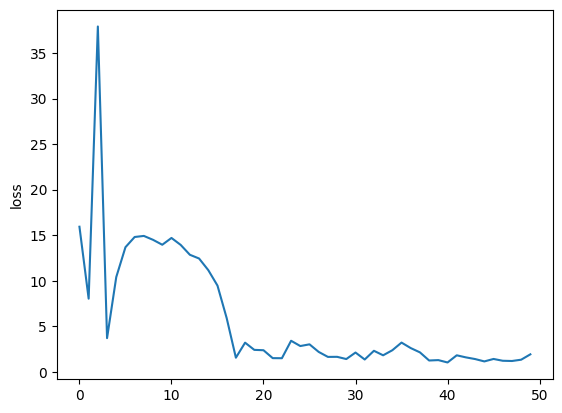

In [55]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

### TensorBoard

In [56]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02-big-local-bandits-rec-bandits-v2/run-20240301-042649/logs (started 109 days, 11:48:14 ago; pid 3837675)
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02x-new-data-loading-v3/run-20240307-012852/logs (started 103 days, 14:54:36 ago; pid 1590886)
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/02b-deep-bandits-rec-bandits-v2/run-20240214-180454/logs (started 124 days, 22:04:06 ago; pid 3029265)


In [57]:
# %load_ext tensorboard
%reload_ext tensorboard

In [58]:
%tensorboard --logdir=$LOG_DIR

# [8] Inference

## load trained policy

In [61]:
POLICY_URI = ARTIFACTS_DIR

print(POLICY_URI)

gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts


In [62]:
from tf_agents.policies import py_tf_eager_policy

trained_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    POLICY_URI, load_specs_from_pbtxt=True
)
trained_policy

## get predictions

TODO - explain bandit_policy_type()

**Dummy arm values?**
* We set `chosen_arm_features` to dummy values of all zeros. We need to save dummy chosen arm features to make the returned policy step have the same structure as the policy state spec.
* `emit_policy_info = ('predicted_rewards_mean', 'bandit_policy_type')` defines what side information we want to get as part of the policy info when we call policy network 
* This makes it so that the model always returns the expected rewards even if the model is exploring
* This means that the largest predicted rewards may not match the selected action when the model is exploring (i.e. bandit_policy == UNIFORM == 2)

**UNIFORM Random policy:**
```
PolicyStep(action=array(1, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.637535 , 3.5557823], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([2], dtype=int32), chosen_arm_features=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)))
```

**GREEDY policy:**
```
PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.8278818, 3.607565 ], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([1], dtype=int32), chosen_arm_features=array([ 0.04054676, -0.04735027,  0.02202327,  0.01276748, -0.01367382,
       -0.04838754,  0.00104916, -0.01956806,  0.01028793, -0.00256665,
       -0.04376553,  0.03900594,  0.02388967, -0.04016995, -0.04945569,
       -0.04539652,  0.04423274, -0.04630332,  0.00390794,  0.03986299,
       -0.0398974 ,  0.01655747, -0.0471294 , -0.00690235, -0.03643382,
       -0.0437116 ,  0.04757959, -0.00991895,  0.0281055 , -0.04633433,
        0.01897702, -0.00824345,  0.03232259, -0.04980658, -0.01144745,
        0.01690939,  0.02536928,  0.03384003, -0.01558131,  0.04731432,
        0.04579857, -0.03305101,  0.03521084, -0.03915765,  0.04927064,
        0.04695194,  0.03792156,  0.040496  ,  0.02574866, -0.00665367,
       -0.03839222, -0.01564004, -0.04710373,  0.03557512, -0.01392462,
        0.01368621,  0.02792176, -0.01799218,  0.00246101,  0.02263175,
        0.0170817 ,  0.01388383, -0.03048695,  0.01198485], dtype=float32)))
```

In [63]:
# eval_ds

In [64]:
INFER_SIZE = 1
dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

SKIP_NUM = 10

for x in eval_ds.skip(SKIP_NUM).take(INFER_SIZE):
    # get feature tensors
    
    global_feat_infer = embs._get_global_context_features(x)
    arm_feat_infer = embs._get_per_arm_features(x)
    
    rewards = _get_rewards(x)
    # rewards = reward_factory._get_rewards(x)
    
    # reshape arm features
    arm_feat_infer = tf.reshape(arm_feat_infer, [HPARAMS['eval_batch_size'], PER_ARM_DIM]) # perarm_dim
    concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)
    
    # flatten global
    flat_global_infer = tf.reshape(global_feat_infer, [GLOBAL_DIM])
    feature = {'global': flat_global_infer, 'per_arm': concat_arm}
    
    # get actual reward
    actual_reward = rewards.numpy()[0]
    
    # build trajectory step
    trajectory_step = train_utils._get_eval_step(feature, actual_reward)
    
    prediction = trained_policy.action(trajectory_step)

In [65]:
trajectory_step

TimeStep(
{'step_type': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'reward': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>,
 'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'observation': {'global': <tf.Tensor: shape=(72,), dtype=float32, numpy=
array([-0.04292719,  0.04092551,  0.00164313,  0.02351327,  0.04287212,
       -0.04820947,  0.00489251,  0.03348509, -0.00715259, -0.04635817,
       -0.0280345 , -0.02419728, -0.00762593, -0.03970023,  0.0328758 ,
        0.00356623,  0.03089395, -0.04285007,  0.00074576,  0.04913807,
        0.01155879, -0.04543854,  0.01926899,  0.01695405, -0.00323045,
       -0.04605979, -0.03148154,  0.00080086, -0.00643566,  0.0359211 ,
       -0.04271328, -0.02065448, -0.01913342,  0.03395179,  0.02617873,
        0.00652635, -0.00321754, -0.00943705, -0.00371711, -0.04780409,
        0.04777852,  0.03597944, -0.00816908,  0.04347155, -0.04431782,
        0.01465065,  0.03527192, -0.03418001,  0.0098835 , -0.00552937,
        0.02409

In [66]:
prediction

PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.2144217, 3.0860393], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([1], dtype=int32), chosen_arm_features=array([-0.01135596, -0.00069731,  0.01456264,  0.01109697,  0.04948247,
       -0.0129439 , -0.03073529, -0.00778619,  0.01339009, -0.00043417,
        0.01239468,  0.04503479, -0.04958885, -0.00905403,  0.00494881,
       -0.04727871,  0.01876009,  0.02605888, -0.04218516, -0.00406491,
       -0.03231323, -0.02579098, -0.02847768,  0.04208817, -0.00918105,
       -0.02859635, -0.02838966, -0.00406081,  0.02150251, -0.00435961,
       -0.01138277, -0.01142308,  0.01113402,  0.04768502, -0.0278921 ,
        0.03287447, -0.0165472 ,  0.03523192,  0.03955123,  0.03419507,
        0.03225485,  0.01191342,  0.01706744, -0.01722114, -0.01353138,
       -0.

In [67]:
prediction.info.predicted_rewards_mean

array([3.2144217, 3.0860393], dtype=float32)

In [68]:
prediction.action

array(0, dtype=int32)

In [69]:
prediction.info.bandit_policy_type

array([1], dtype=int32)

# [9] Prepare training application

To scale this training in Vertex AI's managed training service, we need to package all our code into a python application

* This means, we need to modularize all steps executed up until this point. For example, the training loop we ran above is further parameterized in `train_perarm.py`, which will be called from our `task.py` when we submit the job to Vertex AI
* This training package will eventually be used to create a custom training image (more on that in `04b-build-training-image` notebook)
* For additional details on preparing the training application for Vertex AI, check out [the documentation](https://cloud.google.com/vertex-ai/docs/training/code-requirements) and [this code example](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage2/get_started_vertex_training.ipynb) (which also has good, related commentary)

**The remaining cells will repeat steps executed above**
> we are just illustrating / validating that they are the same

### Distribution strategy

Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:

* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [70]:
from tf_agents.train.utils import strategy_utils

use_gpu = True
use_tpu = False

distribution_strategy = strategy_utils.get_strategy(tpu=use_tpu, use_gpu=use_gpu)
distribution_strategy

In [71]:
NUM_REPLICAS = distribution_strategy.num_replicas_in_sync
NUM_REPLICAS

1

### Vertex Experiments

In [72]:
# using same experiment name 
print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")

EXPERIMENT_NAME   : 02a-sl-bandit-v1


In [73]:
# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

# aiplatform.init(
#     project=PROJECT_ID,
#     location=REGION,
#     experiment=EXPERIMENT_NAME
# )

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02a-sl-bandit-v1
RUN_NAME          : run-20240405-204728

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-204728
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-204728/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-204728/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-204728/artifacts


### Create TensorBoard

In [74]:
# # create new TB instance
TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"

tensorboard = aiplatform.Tensorboard.create(
    display_name=TENSORBOARD_DISPLAY_NAME
    , project=PROJECT_ID
    , location=REGION
)

TB_RESOURCE_NAME = tensorboard.resource_name

TB_ID = TB_RESOURCE_NAME.split('/')[-1]

print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
print(f"TB display name  : {tensorboard.display_name}")
print(f"TB_ID            : {TB_ID}")

TB_RESOURCE_NAME : projects/934903580331/locations/us-central1/tensorboards/3118201782233202688
TB display name  : 02a-sl-bandit-v1-run-20240405-204728
TB_ID            : 3118201782233202688


In [75]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    experiment_tensorboard=TB_ID
)

### trajectory function

In [76]:
# from src import reward_factory as reward_factory

In [77]:
with distribution_strategy.scope():

    embs = emb_features.EmbeddingModel(
        vocab_dict = vocab_dict,
        num_oov_buckets = NUM_OOV_BUCKETS,
        global_emb_size = GLOBAL_EMBEDDING_SIZE,
        mv_emb_size = MV_EMBEDDING_SIZE,
        max_genre_length = data_config.MAX_GENRE_LENGTH
    )

    def _trajectory_fn(element): # hparams
        """
        Converts a dataset element into a trajectory
        """
        global_features = embs._get_global_context_features(element)
        arm_features = embs._get_per_arm_features(element)

        # Adds a time dimension.
        arm_features = train_utils._add_outer_dimension(arm_features)

        # obs spec
        observation = {
            bandit_spec_utils.GLOBAL_FEATURE_KEY:
                train_utils._add_outer_dimension(global_features),
        }

        # reward = train_utils._add_outer_dimension(reward_factory._get_binary_rewards(element))
        reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))

        # To emit the predicted rewards in policy_info, we need to create dummy
        # rewards to match the definition in TensorSpec for the ones specified in
        # emit_policy_info set.
        dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
        policy_info = policy_utilities.PerArmPolicyInfo(
            chosen_arm_features=arm_features,
            # Pass dummy mean rewards here to match the model_spec for emitting
            # mean rewards in policy info
            predicted_rewards_mean=dummy_rewards,
            bandit_policy_type=tf.zeros([HPARAMS['batch_size'], 1, 1], dtype=tf.int32)
        )

        if HPARAMS['model_type'] == 'neural_ucb':
            policy_info = policy_info._replace(
                predicted_rewards_optimistic=dummy_rewards
            )

        return trajectory.single_step(
            observation=observation,
            action=tf.zeros_like(
                reward, 
                dtype=tf.int32
            ),
            policy_info=policy_info,
            reward=reward,
            discount=tf.zeros_like(reward)
        )

### get agent

In [78]:
HPARAMS

{'batch_size': 128,
 'eval_batch_size': 1,
 'num_actions': 2,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'global_layers': [72, 36, 18],
 'per_arm_layers': [64, 32, 16],
 'common_layers': [34, 8],
 'learning_rate': 0.05,
 'epsilon': 0.01,
 'encoding_dim': 1}

In [79]:
with distribution_strategy.scope():

    global_step = tf.compat.v1.train.get_or_create_global_step()

    agent = agent_factory.PerArmAgentFactory._get_agent(
        agent_type = HPARAMS['model_type'],
        network_type = HPARAMS['network_type'],
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        observation_spec=observation_spec,
        global_layers = HPARAMS['global_layers'],
        arm_layers = HPARAMS['per_arm_layers'],
        common_layers = HPARAMS['common_layers'],
        agent_alpha = AGENT_ALPHA,
        learning_rate = HPARAMS['learning_rate'],
        epsilon = HPARAMS['epsilon'],
        train_step_counter = global_step,
        output_dim = HPARAMS['encoding_dim'],
        eps_phase_steps = EPS_PHASE_STEPS,
        summarize_grads_and_vars = False,
        debug_summaries = True
    )

    agent.initialize()

print(f"Agent: {agent.name}")
if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

Agent: NeuralEpsGreedyAgent
Network: commontower


In [80]:
IS_TESTING = True

# train args
NUM_EPOCHS          = 2
TRAINING_LOOPS      = 100
STEPS_PER_LOOP      = 1
drop_arm_feature_fn = None

LOG_INTERVAL        = 10
CHKPT_INTERVAL      = 200
NUM_EVAL_STEPS      = 100

print(f"CHKPT_INTERVAL  : {CHKPT_INTERVAL}")
print(f"eval_batch_size : {EVAL_BATCH_SIZE}")
print(f"NUM_EVAL_STEPS  : {NUM_EVAL_STEPS}")

CHKPT_INTERVAL  : 200
eval_batch_size : 1
NUM_EVAL_STEPS  : 100


In [81]:
# eval dataset
eval_ds = val_dataset.batch(HPARAMS['eval_batch_size'])

if NUM_EVAL_STEPS >= 0:
    with distribution_strategy.scope():
        eval_ds = eval_ds.take(NUM_EVAL_STEPS)

In [82]:
# ====================================================
# TB summary writer
# ====================================================
with distribution_strategy.scope():
    train_summary_writer = tf.compat.v2.summary.create_file_writer(
        f"{LOG_DIR}", flush_millis=10 * 1000
    )
    train_summary_writer.set_as_default()

In [83]:
#start the timer and training
start_time = time.time()

metric_results, agent = train_perarm.train_perarm(
    agent = agent,
    reward_spec = reward_tensor_spec,
    epsilon = HPARAMS['epsilon'],
    global_dim = GLOBAL_DIM,
    per_arm_dim = PER_ARM_DIM,
    num_epochs = NUM_EPOCHS,
    num_iterations = TRAINING_LOOPS,
    steps_per_loop = STEPS_PER_LOOP,
    global_step = global_step,
    train_summary_writer = train_summary_writer,
    strategy = distribution_strategy,
    # data
    batch_size = HPARAMS['batch_size'],
    # functions
    _trajectory_fn = _trajectory_fn,
    # train intervals
    chkpt_interval = CHKPT_INTERVAL,
    log_interval = LOG_INTERVAL,
    # dirs
    bucket_name = BUCKET_NAME,
    data_dir_prefix_path = f"{EXAMPLE_GEN_GCS_PATH}",
    log_dir = LOG_DIR,
    model_dir = ARTIFACTS_DIR,
    chkpoint_dir = CHECKPT_DIR,
    use_gpu = True,
    use_tpu = False,
    profiler = False,
    is_testing = IS_TESTING,
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

distribution_strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f6cbc261c90>
number of train_files: 2
Inpsecting agent policy from train_peram file...
agent.policy: <tf_agents.policies.epsilon_greedy_policy.EpsilonGreedyPolicy object at 0x7f6cbc536ad0>
Inpsecting agent policy from train_peram file: Complete
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/chkpoint
agent.train_step_counter: 50
starting train loop...
epoch: 1
step = 60: loss = 1.3200000524520874
step = 70: loss = 1.5
step = 80: loss = 1.1200000047683716
step = 90: loss = 1.2300000190734863
step = 100: loss = 1.25
step = 110: loss = 1.2699999809265137
step = 120: loss = 1.399999976158142
step = 130: loss = 1.4800000190734863
step = 140: loss = 1.190000057220459
step = 150: loss = 1.2899999618530273
epoch: 2
step = 160: loss = 1.1399999856948853
step = 170: loss = 1.5299999713897705
step = 180: loss = 1.1100000143051147
step = 190: loss = 0.980000019

In [84]:
# len(metric_results)
metric_results[-1]

1.5641303

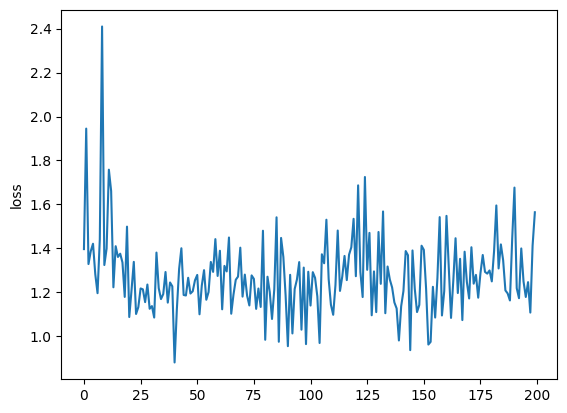

In [85]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

### TensorBoard

In [86]:
# %load_ext tensorboard
%reload_ext tensorboard

In [87]:
%tensorboard --logdir=$LOG_DIR

#### eval trained policy

In [88]:
# tf.executing_eagerly()

After training, our `agent.policy` is used as the deployment "model" that will generate predictions

In [89]:
deployment_agent = agent.policy
deployment_agent

In [90]:
# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(deployment_agent, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = eval_perarm._run_bandit_eval(
    policy = post_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM,
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

evaluating trained Agent...
post-train val_loss     : 1.2889248132705688
post-train eval runtime : 0


## Using Trained Policy

### load trained policy

In [98]:
POLICY_URI = ARTIFACTS_DIR

print(POLICY_URI)

gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts


In [100]:
!gsutil ls $POLICY_URI

gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts/
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts/fingerprint.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts/policy_specs.pbtxt
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts/saved_model.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts/assets/
gs://rec-bandits-v2-hybrid-vertex-bucket/02a-sl-bandit-v1/run-20240405-201400/artifacts/variables/


In [101]:
from tf_agents.policies import py_tf_eager_policy

trained_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    POLICY_URI, load_specs_from_pbtxt=True
)

trained_policy

In [102]:
trained_policy.action_spec

BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action_spec', minimum=0, maximum=1)

In [103]:
INFER_SIZE = 1
dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

SKIP_NUM = 10

for x in eval_ds.skip(SKIP_NUM).take(INFER_SIZE):
    # get feature tensors
    
    # global_feat_infer = _get_global_context_features(x)
    # arm_feat_infer = _get_per_arm_features(x)
    
    global_feat_infer = embs._get_global_context_features(x)
    arm_feat_infer = embs._get_per_arm_features(x)
    
    # rewards = _get_rewards(x)
    rewards = reward_factory._get_rewards(x)
    
    # reshape arm features
    arm_feat_infer = tf.reshape(arm_feat_infer, [HPARAMS['eval_batch_size'], PER_ARM_DIM]) # perarm_dim
    concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)
    
    # flatten global
    flat_global_infer = tf.reshape(global_feat_infer, [GLOBAL_DIM])
    feature = {'global': flat_global_infer, 'per_arm': concat_arm}
    
    # get actual reward
    actual_reward = rewards.numpy()[0]
    
    # build trajectory step
    trajectory_step = train_utils._get_eval_step(feature, actual_reward)
    
    prediction = trained_policy.action(trajectory_step)

In [104]:
trajectory_step

TimeStep(
{'step_type': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'reward': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>,
 'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'observation': {'global': <tf.Tensor: shape=(72,), dtype=float32, numpy=
array([ 0.04241044,  0.00565221,  0.04422763,  0.00134914,  0.04937294,
        0.01381118, -0.01204587, -0.03677445, -0.03586107,  0.02141423,
       -0.0204411 ,  0.00794023, -0.01695096, -0.03990662, -0.0448873 ,
       -0.03649919, -0.02992299, -0.0131296 , -0.04803577, -0.0179759 ,
       -0.04152185, -0.02244627,  0.00479592,  0.02592236, -0.00028305,
       -0.02112672,  0.00661103, -0.01207937, -0.0475125 ,  0.02755028,
        0.00544388, -0.01051931, -0.04899287, -0.04464852,  0.02944926,
       -0.03342316,  0.02410597, -0.00887365, -0.03602239, -0.0092517 ,
        0.02572869, -0.04339042, -0.04558343,  0.02309335, -0.01735141,
       -0.03902184,  0.00737535, -0.03913713,  0.03108293, -0.00903713,
        0.03314

### view prediction response

In [105]:
prediction

PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.036196 , 2.9538894], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([1], dtype=int32), chosen_arm_features=array([-0.04530438,  0.02410534,  0.03922541,  0.02301642,  0.01503695,
        0.00977764,  0.03505062,  0.03296139, -0.0342198 , -0.03755862,
       -0.02153118, -0.04079999, -0.00767606, -0.01296829,  0.04210228,
       -0.04536079, -0.03534019,  0.00950712,  0.01481284,  0.00858416,
       -0.0120965 ,  0.01018442,  0.04002163,  0.01259043,  0.01181433,
        0.02138977, -0.03248683,  0.03199745,  0.0109346 ,  0.0141496 ,
       -0.00214201, -0.02767802,  0.01023891,  0.01535262,  0.04537851,
       -0.00275371, -0.02801061,  0.02432204,  0.01902026,  0.03563782,
        0.00583049, -0.00079752,  0.0035071 , -0.04984921, -0.03131267,
       -0.

#### chosen action

In [106]:
prediction.action

array(0, dtype=int32)

#### Per Arm Policy Info

In [107]:
prediction.info

PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.036196 , 2.9538894], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([1], dtype=int32), chosen_arm_features=array([-0.04530438,  0.02410534,  0.03922541,  0.02301642,  0.01503695,
        0.00977764,  0.03505062,  0.03296139, -0.0342198 , -0.03755862,
       -0.02153118, -0.04079999, -0.00767606, -0.01296829,  0.04210228,
       -0.04536079, -0.03534019,  0.00950712,  0.01481284,  0.00858416,
       -0.0120965 ,  0.01018442,  0.04002163,  0.01259043,  0.01181433,
        0.02138977, -0.03248683,  0.03199745,  0.0109346 ,  0.0141496 ,
       -0.00214201, -0.02767802,  0.01023891,  0.01535262,  0.04537851,
       -0.00275371, -0.02801061,  0.02432204,  0.01902026,  0.03563782,
        0.00583049, -0.00079752,  0.0035071 , -0.04984921, -0.03131267,
       -0.04805095, -0.03137206,  0.03806898,  0.11712466, -0.0181

**Finished**